In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
# import os
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats

# Import Ngl with pyn_env active 
# import Ngl

## Need to use metPy conda env
# import metpy.calc as mpc
# from metpy.units import units

import warnings
warnings.filterwarnings('ignore')



## Read in data

In [2]:
# start_time = time.time()

# saveDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/ProcessedFiles/'

# HMGcamDS_localReal        = pickle.load( open( saveDir+"HMGcamDS_localReal.p", "rb" ) )
# HTGcamDS_localReal        = pickle.load( open( saveDir+"HTGcamDS_localReal.p", "rb" ) )
# HTGcamDS_localReal10      = pickle.load( open( saveDir+"HTGcamDS_localReal10.p", "rb" ) )

# HMGclmDS_localReal        = pickle.load( open( saveDir+"HMGclmDS_localReal.p", "rb" ) )
# HTGclmDS_localReal        = pickle.load( open( saveDir+"HTGclmDS_localReal.p", "rb" ) )
# HTGclmDS_localReal10      = pickle.load( open( saveDir+"HTGclmDS_localReal10.p", "rb" ) )

# HMGclmDS_localRealPatch   = pickle.load( open( saveDir+"HMGclmDS_localRealPatch.p", "rb" ) )
# HTGclmDS_localRealPatch   = pickle.load( open( saveDir+"HTGclmDS_localRealPatch.p", "rb" ) )
# HTGclmDS_localRealPatch10 = pickle.load( open( saveDir+"HTGclmDS_localRealPatch10.p", "rb" ) )

# print('Loaded all the real_sfc pickle files')

# HMGcamDS_localArt        = pickle.load( open( saveDir+"HMGcamDS_localArt.p", "rb" ) )
# HTGcamDS_localArt        = pickle.load( open( saveDir+"HTGcamDS_localArt.p", "rb" ) )
# HTGcamDS_localArt5       = pickle.load( open( saveDir+"HTGcamDS_localArt5.p", "rb" ) )
# HTGcamDS_localArt25      = pickle.load( open( saveDir+"HTGcamDS_localArt25.p", "rb" ) )

# HMGclmDS_localArt        = pickle.load( open( saveDir+"HMGclmDS_localArt.p", "rb" ) )
# HTGclmDS_localArt        = pickle.load( open( saveDir+"HTGclmDS_localArt.p", "rb" ) )
# HTGclmDS_localArt5       = pickle.load( open( saveDir+"HTGclmDS_localArt5.p", "rb" ) )
# HTGclmDS_localArt25      = pickle.load( open( saveDir+"HTGclmDS_localArt25.p", "rb" ) )

# HMGclmDS_localArtPatch   = pickle.load( open( saveDir+"HMGclmDS_localArtPatch.p", "rb" ) )
# HTGclmDS_localArtPatch   = pickle.load( open( saveDir+"HTGclmDS_localArtPatch.p", "rb" ) )

# print('Loaded all the artificial_sfc pickle files')

# print('Total elapsed time (sec): ', time.time()-start_time)


Loaded all the real_sfc pickle files
Loaded all the artificial_sfc pickle files
Total elapsed time (sec):  24.14574384689331


In [2]:
start_time = time.time()

saveDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/ProcessedFiles/'

realSfc_allCases          = pickle.load( open( saveDir+"realSfc_allCases_withInterp.p", "rb" ) )

HMGclmDS_localReal        = pickle.load( open( saveDir+"HMGclmDS_localReal.p", "rb" ) )
HTGclmDS_localReal        = pickle.load( open( saveDir+"HTGclmDS_localReal.p", "rb" ) )
HTGclmDS_localReal10      = pickle.load( open( saveDir+"HTGclmDS_localReal10.p", "rb" ) )

print('Loaded all the real_sfc pickle files')

artSfc_allCases        = pickle.load( open( saveDir+"artSfc_allCases_withInterp.p", "rb" ) )
artSfcMult_allCases    = pickle.load( open( saveDir+"artSfcMult_allCases_withInterp.p", "rb" ) )

HMGclmDS_localArt        = pickle.load( open( saveDir+"HMGclmDS_localArt.p", "rb" ) )
HTGclmDS_localArt        = pickle.load( open( saveDir+"HTGclmDS_localArt.p", "rb" ) )
HTGclmDS_localArt5       = pickle.load( open( saveDir+"HTGclmDS_localArt5.p", "rb" ) )
HTGclmDS_localArt25      = pickle.load( open( saveDir+"HTGclmDS_localArt25.p", "rb" ) )

print('Loaded all the artificial_sfc pickle files')

print('Total elapsed time (sec): ', time.time()-start_time)


Loaded all the real_sfc pickle files
Loaded all the artificial_sfc pickle files
Total elapsed time (sec):  46.450713872909546


In [3]:
## Large-scale forcing data:
nateForcingFileHTG = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-htg.nc'
nateDS_HTG = xr.open_dataset(nateForcingFileHTG, decode_times='True')

nateForcingFileHMG = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-hmg.nc'
nateDS_HMG = xr.open_dataset(nateForcingFileHMG, decode_times='True')

## Convert to local time too 
nateDS_local       = nateDS_HTG.copy(deep=True)

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = nateDS_local['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
nateDS_local = nateDS_local.assign_coords({"time": localTimes})

# Add month_day index
month_day_idx                      = pd.MultiIndex.from_arrays([nateDS_local['time.year'].values,
                                                                nateDS_local['time.month'].values, 
                                                                nateDS_local['time.day'].values])
nateDS_local.coords['year_month_day'] = ('time', month_day_idx)

# Now sum over the day to get total amount of rainfall
nateDS_localDailySum = nateDS_local.groupby('year_month_day').sum()


### Add in month-day index

In [4]:
# Add month_day index to arrays
month_day_idx                      = pd.MultiIndex.from_arrays([HMGclmDS_localReal['time.year'].values,
                                                                HMGclmDS_localReal['time.month'].values, 
                                                                HMGclmDS_localReal['time.day'].values])

realSfc_allCases.coords['year_month_day']        = ('time', month_day_idx)

HMGclmDS_localReal.coords['year_month_day']      = ('time', month_day_idx)
HMGclmDS_localRealPatch.coords['year_month_day'] = ('time', month_day_idx)

HTGclmDS_localReal.coords['year_month_day']      = ('time', month_day_idx)

HTGclmDS_localReal10.coords['year_month_day']      = ('time', month_day_idx)


artSfc_allCases.coords['year_month_day']      = ('time', month_day_idx)
artSfcMult_allCases.coords['year_month_day']  = ('time', month_day_idx)

HMGclmDS_localArt.coords['year_month_day']      = ('time', month_day_idx)

HTGclmDS_localArt.coords['year_month_day']      = ('time', month_day_idx)

HTGclmDS_localArt5.coords['year_month_day']     = ('time', month_day_idx)

HTGclmDS_localArt25.coords['year_month_day']    = ('time', month_day_idx)


## Get days based on a classification method

In [8]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnDayClass(fullDS, dayClassDS):
    iTimes = []
    
    for iTime in range(len(dayClassDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==dayClassDS.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==dayClassDS.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==dayClassDS.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayClass = fullDS.isel(time=iTimes)
    
    return(DS_dayClass)



In [9]:
## Load wet/dry day arrays from pickle file (saved 11/3/2021)
saveDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/ProcessedFiles/'

artSfc_allCasesDailySum_dDry        = pickle.load( open( saveDir+"artSfc_allCasesDailySum_dDry.p", "rb" ) )
artSfc_allCasesDailySum_wWet        = pickle.load( open( saveDir+"artSfc_allCasesDailySum_wWet.p", "rb" ) )



In [10]:
# Next, get all the times in the full array that line up with each of those classifications above 

dDryDays_realSfc     = getTimes_basedOnDayClass(realSfc_allCases,     artSfc_allCasesDailySum_dDry)
dDryDays_artSfc      = getTimes_basedOnDayClass(artSfc_allCases,      artSfc_allCasesDailySum_dDry)
dDryDays_artSfcMult  = getTimes_basedOnDayClass(artSfcMult_allCases,  artSfc_allCasesDailySum_dDry)

wWetDays_realSfc     = getTimes_basedOnDayClass(realSfc_allCases,     artSfc_allCasesDailySum_wWet)
wWetDays_artSfc      = getTimes_basedOnDayClass(artSfc_allCases,      artSfc_allCasesDailySum_wWet)
wWetDays_artSfcMult  = getTimes_basedOnDayClass(artSfcMult_allCases,  artSfc_allCasesDailySum_wWet)


In [11]:
## Get the same dDry and wWet dates in the forcing files 
dDryDays_obs = getTimes_basedOnDayClass(nateDS_local, artSfc_allCasesDailySum_dDry)
wWetDays_obs = getTimes_basedOnDayClass(nateDS_local, artSfc_allCasesDailySum_wWet)


In [12]:
# Get all those times in the CLM land files as well 
dDryDaysCLM_HTGreal = getTimes_basedOnDayClass(HTGclmDS_localReal, artSfc_allCasesDailySum_dDry)
wWetDaysCLM_HTGreal = getTimes_basedOnDayClass(HTGclmDS_localReal, artSfc_allCasesDailySum_wWet)

dDryDaysCLM_HMGreal = getTimes_basedOnDayClass(HMGclmDS_localReal, artSfc_allCasesDailySum_dDry)
wWetDaysCLM_HMGreal = getTimes_basedOnDayClass(HMGclmDS_localReal, artSfc_allCasesDailySum_wWet)


dDryDaysCLM_HTGart  = getTimes_basedOnDayClass(HTGclmDS_localArt, artSfc_allCasesDailySum_dDry)
wWetDaysCLM_HTGart  = getTimes_basedOnDayClass(HTGclmDS_localArt, artSfc_allCasesDailySum_wWet)

dDryDaysCLM_HMGart  = getTimes_basedOnDayClass(HMGclmDS_localArt, artSfc_allCasesDailySum_dDry)
wWetDaysCLM_HMGart  = getTimes_basedOnDayClass(HMGclmDS_localArt, artSfc_allCasesDailySum_wWet)


**Now get hourly means/std as well**

In [13]:
hourlyMean_dDry_realSfc    = dDryDays_realSfc.groupby("time.hour").mean(dim="time")
hourlyMean_dDry_artSfc     = dDryDays_artSfc.groupby("time.hour").mean(dim="time")
hourlyMean_dDry_artSfcMult = dDryDays_artSfcMult.groupby("time.hour").mean(dim="time")

hourlyMean_wWet_realSfc    = wWetDays_realSfc.groupby("time.hour").mean(dim="time")
hourlyMean_wWet_artSfc     = wWetDays_artSfc.groupby("time.hour").mean(dim="time")
hourlyMean_wWet_artSfcMult = wWetDays_artSfcMult.groupby("time.hour").mean(dim="time")


print('Computed hourly means for all surfaces + cases')



Computed hourly means for all surfaces + cases


In [15]:
# # And CLMvariables for mean
# hourlyMeanCLM_dDry_HMGreal = dDryDaysCLM_HMGreal.groupby("time.hour").mean()
# hourlyMeanCLM_dDry_HTGreal = dDryDaysCLM_HTGreal.groupby("time.hour").mean()

# hourlyMeanCLM_wWet_HMGreal = wWetDaysCLM_HMGreal.groupby("time.hour").mean()
# hourlyMeanCLM_wWet_HTGreal = wWetDaysCLM_HTGreal.groupby("time.hour").mean()


# hourlyMeanCLM_dDry_HMGart = dDryDaysCLM_HMGart.groupby("time.hour").mean()
# hourlyMeanCLM_dDry_HTGart = dDryDaysCLM_HTGart.groupby("time.hour").mean()

# hourlyMeanCLM_wWet_HMGart = wWetDaysCLM_HMGart.groupby("time.hour").mean()
# hourlyMeanCLM_wWet_HTGart = wWetDaysCLM_HTGart.groupby("time.hour").mean()

In [15]:
# Get number of obs going into those hourly means (for error bars)
nTimes_dDry   = np.full([24], np.nan)
nTimes_wWet   = np.full([24], np.nan)

for iHr in range(24): 
    nTimes_dDry[iHr]  = len(np.where(dDryDays_realSfc["time.hour"]==iHr)[0])
    nTimes_wWet[iHr]  = len(np.where(wWetDays_realSfc["time.hour"]==iHr)[0])

hourlyMean_dDry_realSfc['SampleCount']       = (('hour'), nTimes_dDry)
hourlyMean_dDry_artSfc['SampleCount']        = (('hour'), nTimes_dDry)
hourlyMean_dDry_artSfcMult['SampleCount']    = (('hour'), nTimes_dDry)

hourlyMean_wWet_realSfc['SampleCount']       = (('hour'), nTimes_wWet)
hourlyMean_wWet_artSfc['SampleCount']        = (('hour'), nTimes_wWet)
hourlyMean_wWet_artSfcMult['SampleCount']    = (('hour'), nTimes_wWet)


In [17]:
hourlyMean_dDry_Obs  = dDryDays_obs.groupby("time.hour").mean()
hourlyMean_wWet_Obs  = wWetDays_obs.groupby("time.hour").mean()

# Get number of obs going into those hourly means (for error bars)
nTimes_dDryObs   = np.full([24], np.nan)
nTimes_wWetObs   = np.full([24], np.nan)

for iHr in range(24): 
    nTimes_dDryObs[iHr]  = len(np.where(dDryDays_obs["time.hour"]==iHr)[0])
    nTimes_wWetObs[iHr]  = len(np.where(wWetDays_obs["time.hour"]==iHr)[0])
    
hourlyMean_dDry_Obs['SampleCount'] = (('hour'), nTimes_dDryObs)
hourlyMean_wWet_Obs['SampleCount'] = (('hour'), nTimes_wWetObs)



## Plot mixing diagrams
Drawing heavily from Ahmed's NCL CoMeT scripts (saved here, locally: <br> /Users/mdfowler/Documents/Analysis/Coupling_initial/coupling-metrics/mixing_diagram/ncl_portable) 
<br>
Note, this script does seem to use regular 2m T, not 2m theta (operating on assumption that they are approximately equal that close to the surface)

In [18]:
## Set some constants 
Lv = 2.5e6      # Latent heat of vaporization
Cp = 1005.7     # Specific heat capacity 
g  = 9.8 
Rd = 287.04
ep = 0.622
R_cp = Rd/Cp 

# Time increment of time dimension (seconds) 
# dt = 60.0*60.0    # Using hourly values  


In [19]:
def air_density(p, t, q):
    '''Calculate the air density using the ideal gas law
    with the specific humidity of gas

    Parameters
    ----------
    p : float
        pressure [Pascals]
    t : float
        dry bulb temperature [Kelvin]
    q : float
        specific humidity [kg/kg]

    Return
    ------
    float
        air density [kg/m^3]
    '''
    return p / (Rd * t * ((1. + (q/ep)) / (1. + q)))


**Dry Days**

In [82]:
# Variable name for PBL variable
PBLname = 'PBLH'

# Select just 7a-7p: 
iHours              = np.where((hourlyMean_dDry_realSfc.hour.values>=7) & (hourlyMean_dDry_realSfc.hour.values<=19))[0]

realSfc_daytime     = hourlyMean_dDry_realSfc.isel(hour=iHours)
artSfc_daytime      = hourlyMean_dDry_artSfc.isel(hour=iHours)
artSfcMult_daytime  = hourlyMean_dDry_artSfcMult.isel(hour=iHours)


rho_real     = air_density(realSfc_daytime.PS.values,    realSfc_daytime.TREFHT.values,    realSfc_daytime.QREFHT.values)
rho_art      = air_density(artSfc_daytime.PS.values,     artSfc_daytime.TREFHT.values,     artSfc_daytime.QREFHT.values)
rho_artMult  = air_density(artSfcMult_daytime.PS.values, artSfcMult_daytime.TREFHT.values, artSfcMult_daytime.QREFHT.values)

realSfc_daytime['rho'] = (('hour','case','lat','lon'), rho_real)
artSfc_daytime['rho'] = (('hour','case','lat','lon'), rho_art)
artSfcMult_daytime['rho'] = (('hour','case','lat','lon'), rho_artMult)

# Get mean over daytime hours
realSfc_daytimeMean    = realSfc_daytime.mean(dim='hour')
artSfc_daytimeMean     = artSfc_daytime.mean(dim='hour')
artMultSfc_daytimeMean = artSfcMult_daytime.mean(dim='hour')

## Get points for Cp_delTheta and L_delQ 
real_Cp_delTheta = (np.squeeze(realSfc_daytimeMean.SHFLX.values)*(13*60*60))/(np.squeeze(realSfc_daytimeMean.rho.values )* np.squeeze(realSfc_daytimeMean[PBLname].values))
bowen_real       = np.squeeze(realSfc_daytimeMean.SHFLX.values)/np.squeeze(realSfc_daytimeMean.LHFLX.values)
real_L_delQ      = real_Cp_delTheta/bowen_real

art_Cp_delTheta = (np.squeeze(artSfc_daytimeMean.SHFLX.values)*(13*60*60))/(np.squeeze(artSfc_daytimeMean.rho.values )* np.squeeze(artSfc_daytimeMean[PBLname].values))
bowen_art       = np.squeeze(artSfc_daytimeMean.SHFLX.values)/np.squeeze(artSfc_daytimeMean.LHFLX.values)
art_L_delQ      = art_Cp_delTheta/bowen_art

artMult_Cp_delTheta = (np.squeeze(artMultSfc_daytimeMean.SHFLX.values)*(13*60*60))/(np.squeeze(artMultSfc_daytimeMean.rho.values )* np.squeeze(artMultSfc_daytimeMean[PBLname].values))
bowen_artMult       = np.squeeze(artMultSfc_daytimeMean.SHFLX.values)/np.squeeze(artMultSfc_daytimeMean.LHFLX.values)
artMult_L_delQ      = artMult_Cp_delTheta/bowen_artMult



In [68]:
caseNames = np.asarray(['HMG','HTG','HTG*10'])
print('Real Surface Bowen_entrainment: ')
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', bowen_real[iCase])
    
print()

print('Artificial Surface Bowen_entrainment: ')
caseNames = np.asarray(['HMG', 'HTG'])
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', bowen_art[iCase])
    
caseNames = np.asarray(['HTG*0.5', 'HTG*0.25'])
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', bowen_artMult[iCase])    
    
    

Real Surface Bowen_entrainment: 
HMG    :   0.91479594
HTG    :   0.88291556
HTG*10    :   0.8774247

Artificial Surface Bowen_entrainment: 
HMG    :   1.0676924
HTG    :   1.118415
HTG*0.5    :   1.0977129
HTG*0.25    :   1.1129409


In [70]:
caseNames = np.asarray(['HMG','HTG','HTG*10'])
print('Real Surface rho: ')
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', realSfc_daytimeMean.rho.values[iCase])
    
print()

print('Artificial Surface rho: ')
caseNames = np.asarray(['HMG', 'HTG'])
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', artSfc_daytimeMean.rho.values[iCase])
    
caseNames = np.asarray(['HTG*0.5', 'HTG*0.25'])
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', artMultSfc_daytimeMean.rho.values[iCase])    
    
    

Real Surface rho: 
HMG    :   [[1.0882862]]
HTG    :   [[1.0914536]]
HTG*10    :   [[1.0899646]]

Artificial Surface rho: 
HMG    :   [[1.0822495]]
HTG    :   [[1.0817628]]
HTG*0.5    :   [[1.0826615]]
HTG*0.25    :   [[1.0815263]]


In [71]:
caseNames = np.asarray(['HMG','HTG','HTG*10'])
print('Real Surface %s: ' % PBLname)
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', realSfc_daytimeMean[PBLname].values[iCase])
    
print()

print('Artificial Surface %s: ' % PBLname)
caseNames = np.asarray(['HMG', 'HTG'])
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', artSfc_daytimeMean[PBLname].values[iCase])
    
caseNames = np.asarray(['HTG*0.5', 'HTG*0.25'])
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', artMultSfc_daytimeMean[PBLname].values[iCase])    
    
    

Real Surface PBLH: 
HMG    :   [[1558.5715]]
HTG    :   [[1447.5966]]
HTG*10    :   [[1401.4226]]

Artificial Surface PBLH: 
HMG    :   [[1801.4473]]
HTG    :   [[1625.468]]
HTG*0.5    :   [[1723.5823]]
HTG*0.25    :   [[1753.9895]]


In [83]:
real_LvQ = hourlyMean_dDry_realSfc.QREFHT.values[7:20,:,0,0]*Lv
real_CpT = hourlyMean_dDry_realSfc.TREFHT.values[7:20,:,0,0]*Cp

art_LvQ  = hourlyMean_dDry_artSfc.QREFHT.values[7:20,:,0,0]*Lv
art_CpT  = hourlyMean_dDry_artSfc.TREFHT.values[7:20,:,0,0]*Cp

artMult_LvQ  = hourlyMean_dDry_artSfcMult.QREFHT.values[7:20,:,0,0]*Lv
artMult_CpT  = hourlyMean_dDry_artSfcMult.TREFHT.values[7:20,:,0,0]*Cp


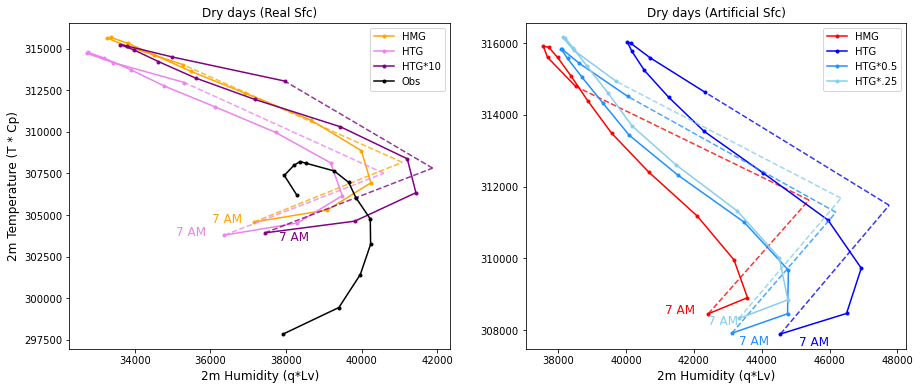

In [84]:
# Make the plots! 
fig,axs = plt.subplots(1,2, figsize=(15,6))
axs     = axs.ravel()


## Plot real surface
# - - - - - - - - - - - 

caseNames = np.asarray(['HMG','HTG','HTG*10'])
colorList = np.asarray(['orange','violet','purple'])
offset_7aText = np.asarray([ [0.97, 0.965, 1.01], 
                             [1.0,  1.0,   0.9985] ])


for iCase in range(3):
    axs[0].plot(real_LvQ[:,iCase], real_CpT[:,iCase],'o-',
                markersize=3, color=colorList[iCase], label=caseNames[iCase])
    
    # Add vectors
    axs[0].plot([real_LvQ[0,iCase], real_LvQ[0,iCase]+real_L_delQ[iCase]], 
                [real_CpT[0,iCase], real_CpT[0,iCase]+real_Cp_delTheta[iCase]],
                '--', color=colorList[iCase], alpha=0.8)
    axs[0].plot([real_LvQ[0,iCase]+real_L_delQ[iCase], real_LvQ[-1,iCase]], 
                [real_CpT[0,iCase]+real_Cp_delTheta[iCase], real_CpT[-1,iCase]],
                '--', color=colorList[iCase], alpha=0.8)
    # Add 7 am labels
    axs[0].text(real_LvQ[0,iCase]*offset_7aText[0,iCase], 
                real_CpT[0,iCase]*offset_7aText[1,iCase], '7 AM', color=colorList[iCase], fontsize=12)
    
# ## Plot observations T/Q:
# # - - - - - - - - - - - 
axs[0].plot( hourlyMean_dDry_Obs.q_srf.values[7:20]*Lv, 
            (hourlyMean_dDry_Obs.T_srf.values[7:20]+273.15)*Cp,'o-',
                markersize=3, color='k', label='Obs')


## Plot artificial surface
# - - - - - - - - - - - 
caseNames = np.asarray(['HMG','HTG'])
colorList = np.asarray(['red','blue'])
offset_7aText = np.asarray([ [0.97, 1.012 ], 
                             [1.0,  0.999   ] ])

for iCase in range(2): 
    axs[1].plot(art_LvQ[:,iCase], art_CpT[:,iCase],'o-',
                markersize=3, color=colorList[iCase], label=caseNames[iCase])
    
    # Add vectors
    axs[1].plot([art_LvQ[0,iCase], art_LvQ[0,iCase]+art_L_delQ[iCase]], 
                [art_CpT[0,iCase], art_CpT[0,iCase]+art_Cp_delTheta[iCase]],
                '--', color=colorList[iCase], alpha=0.8)
    axs[1].plot([art_LvQ[0,iCase]+art_L_delQ[iCase], art_LvQ[-1,iCase]], 
                [art_CpT[0,iCase]+art_Cp_delTheta[iCase], art_CpT[-1,iCase]],
                '--', color=colorList[iCase], alpha=0.8)
    # Add 7 am labels
    axs[1].text(art_LvQ[0,iCase]*offset_7aText[0,iCase], 
                art_CpT[0,iCase]*offset_7aText[1,iCase], '7 AM', color=colorList[iCase], fontsize=12)
    
# Add multipliers
caseNames = np.asarray(['HTG*0.5','HTG*.25'])
colorList = np.asarray(['dodgerblue','skyblue'])
offset_7aText = np.asarray([ [1.005,  0.979 ], 
                             [0.999,  0.9995   ] ])

for iCase in range(2): 
    axs[1].plot(artMult_LvQ[:,iCase], artMult_CpT[:,iCase],'o-',
                markersize=3, color=colorList[iCase], label=caseNames[iCase])
    
    # Add vectors
    axs[1].plot([artMult_LvQ[0,iCase], artMult_LvQ[0,iCase]+artMult_L_delQ[iCase]], 
                [artMult_CpT[0,iCase], artMult_CpT[0,iCase]+artMult_Cp_delTheta[iCase]],
                '--', color=colorList[iCase], alpha=0.8)
    axs[1].plot([artMult_LvQ[0,iCase]+artMult_L_delQ[iCase], artMult_LvQ[-1,iCase]], 
                [artMult_CpT[0,iCase]+artMult_Cp_delTheta[iCase], artMult_CpT[-1,iCase]],
                '--', color=colorList[iCase], alpha=0.8)
    # Add 7 am labels
    axs[1].text(artMult_LvQ[0,iCase]*offset_7aText[0,iCase], 
                artMult_CpT[0,iCase]*offset_7aText[1,iCase], '7 AM', color=colorList[iCase], fontsize=12)
    




## Add titles/labels 
# - - - - - - - - - - - 
axs[0].set_ylabel('2m Temperature (T * Cp)', fontsize=12)
axs[0].set_xlabel('2m Humidity (q*Lv)',fontsize=12)
axs[1].set_xlabel('2m Humidity (q*Lv)',fontsize=12)


axs[0].set_title('Dry days (Real Sfc)')
axs[1].set_title('Dry days (Artificial Sfc)')

axs[0].legend()
axs[1].legend()


In [89]:
nateDS_local.T_srf.units

'C'

In [66]:
# The slope of the top vector is exactly equal to the bowen ratio of entrainment. 
#   Slope = rise/run 

caseNames = np.asarray(['HMG','HTG','HTG*10'])
bowen_entrainment_real = ( real_CpT[-1,:] - (real_CpT[0,:]+real_Cp_delTheta[:]) ) / ( real_LvQ[-1,:] - (real_LvQ[0,:]+real_L_delQ[:][:]) ) 

print('Real Surface Bowen_entrainment: ')
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', bowen_entrainment_real[iCase])
    
print('\nReal Surface V_sfc: ')
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', np.sqrt(real_Cp_delTheta[iCase]**2 + real_L_delQ[iCase]**2))
    

Real Surface Bowen_entrainment: 
HMG    :   -1.0120921
HTG    :   -1.0338113
HTG*10    :   -1.3367058

Real Surface V_sfc: 
HMG    :   5323.172741221816
HTG    :   5623.3350389470115
HTG*10    :   5902.861895265939


In [67]:
# The slope of the top vector is exactly equal to the bowen ratio of entrainment. 
#   Slope = rise/run 

caseNames = np.asarray(['HMG','HTG','HTG*0.5','HTG*0.25'])

bowen_entrainment_art     = ( art_CpT[-1,:]     - (art_CpT[0,:]+art_Cp_delTheta[:]) )         / ( art_LvQ[-1,:]  - (art_LvQ[0,:]+art_L_delQ[:])) 
bowen_entrainment_artMult = ( artMult_CpT[-1,:] - (artMult_CpT[0,:]+artMult_Cp_delTheta[:]) ) / ( artMult_LvQ[-1,:] - (artMult_LvQ[0,:]+artMult_L_delQ[:]) ) 

bowen_entrainmentArtAll = np.append(bowen_entrainment_art, bowen_entrainment_artMult)
Cp_delTheta_artAll      = np.append(art_Cp_delTheta, artMult_Cp_delTheta)
L_delQ_artAll           = np.append(art_L_delQ, artMult_L_delQ)

print('Artificial Surface Bowen_entrainment: ')
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', bowen_entrainmentArtAll[iCase])
    
print('\nArtificial Surface V_sfc: ')
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', np.sqrt(Cp_delTheta_artAll[iCase]**2 + L_delQ_artAll[iCase]**2))
    
    

Artificial Surface Bowen_entrainment: 
HMG    :   -0.4602655
HTG    :   -0.5801624
HTG*0.5    :   -0.52584547
HTG*0.25    :   -0.4909914

Artificial Surface V_sfc: 
HMG    :   4345.196311005456
HTG    :   4813.678918651605
HTG*0.5    :   4562.081851600725
HTG*0.25    :   4508.616327336506


**Wet Days**

In [85]:
del realSfc_daytime
del artSfc_daytime
del artSfcMult_daytime

In [86]:
# Variable name for PBL variable
PBLname = 'PBLH'

# Select just 7a-7p: 
iHours              = np.where((hourlyMean_wWet_realSfc.hour.values>=7) & (hourlyMean_wWet_realSfc.hour.values<=19))[0]

realSfc_daytime     = hourlyMean_wWet_realSfc.isel(hour=iHours)
artSfc_daytime      = hourlyMean_wWet_artSfc.isel(hour=iHours)
artSfcMult_daytime  = hourlyMean_wWet_artSfcMult.isel(hour=iHours)


rho_real     = air_density(realSfc_daytime.PS.values,    realSfc_daytime.TREFHT.values,    realSfc_daytime.QREFHT.values)
rho_art      = air_density(artSfc_daytime.PS.values,     artSfc_daytime.TREFHT.values,     artSfc_daytime.QREFHT.values)
rho_artMult  = air_density(artSfcMult_daytime.PS.values, artSfcMult_daytime.TREFHT.values, artSfcMult_daytime.QREFHT.values)

realSfc_daytime['rho'] = (('hour','case','lat','lon'), rho_real)
artSfc_daytime['rho'] = (('hour','case','lat','lon'), rho_art)
artSfcMult_daytime['rho'] = (('hour','case','lat','lon'), rho_artMult)

# Get mean over daytime hours
realSfc_daytimeMean    = realSfc_daytime.mean(dim='hour')
artSfc_daytimeMean     = artSfc_daytime.mean(dim='hour')
artMultSfc_daytimeMean = artSfcMult_daytime.mean(dim='hour')

## Get points for Cp_delTheta and L_delQ 
real_Cp_delTheta = (np.squeeze(realSfc_daytimeMean.SHFLX.values)*(13*60*60))/(np.squeeze(realSfc_daytimeMean.rho.values )* np.squeeze(realSfc_daytimeMean[PBLname].values))
bowen_real       = np.squeeze(realSfc_daytimeMean.SHFLX.values)/np.squeeze(realSfc_daytimeMean.LHFLX.values)
real_L_delQ      = real_Cp_delTheta/bowen_real

art_Cp_delTheta = (np.squeeze(artSfc_daytimeMean.SHFLX.values)*(13*60*60))/(np.squeeze(artSfc_daytimeMean.rho.values )* np.squeeze(artSfc_daytimeMean[PBLname].values))
bowen_art       = np.squeeze(artSfc_daytimeMean.SHFLX.values)/np.squeeze(artSfc_daytimeMean.LHFLX.values)
art_L_delQ      = art_Cp_delTheta/bowen_art

artMult_Cp_delTheta = (np.squeeze(artMultSfc_daytimeMean.SHFLX.values)*(13*60*60))/(np.squeeze(artMultSfc_daytimeMean.rho.values )* np.squeeze(artMultSfc_daytimeMean[PBLname].values))
bowen_artMult       = np.squeeze(artMultSfc_daytimeMean.SHFLX.values)/np.squeeze(artMultSfc_daytimeMean.LHFLX.values)
artMult_L_delQ      = artMult_Cp_delTheta/bowen_artMult



In [74]:
caseNames = np.asarray(['HMG','HTG','HTG*10'])
print('Real Surface Bowen_entrainment: ')
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', bowen_real[iCase])
    
print()

print('Artificial Surface Bowen_entrainment: ')
caseNames = np.asarray(['HMG', 'HTG'])
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', bowen_art[iCase])
    
caseNames = np.asarray(['HTG*0.5', 'HTG*0.25'])
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', bowen_artMult[iCase])    
    
    

Real Surface Bowen_entrainment: 
HMG    :   0.27998662
HTG    :   0.30382028
HTG*10    :   0.29629728

Artificial Surface Bowen_entrainment: 
HMG    :   0.34592792
HTG    :   0.33060917
HTG*0.5    :   0.34028846
HTG*0.25    :   0.33063972


In [75]:
caseNames = np.asarray(['HMG','HTG','HTG*10'])
print('Real Surface rho: ')
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', realSfc_daytimeMean.rho.values[iCase])
    
print()

print('Artificial Surface rho: ')
caseNames = np.asarray(['HMG', 'HTG'])
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', artSfc_daytimeMean.rho.values[iCase])
    
caseNames = np.asarray(['HTG*0.5', 'HTG*0.25'])
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', artMultSfc_daytimeMean.rho.values[iCase])    
    
    

Real Surface rho: 
HMG    :   [[1.10225]]
HTG    :   [[1.1050462]]
HTG*10    :   [[1.103893]]

Artificial Surface rho: 
HMG    :   [[1.0963616]]
HTG    :   [[1.095525]]
HTG*0.5    :   [[1.0966514]]
HTG*0.25    :   [[1.0959855]]


In [76]:
caseNames = np.asarray(['HMG','HTG','HTG*10'])
print('Real Surface %s: ' % PBLname)
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', realSfc_daytimeMean[PBLname].values[iCase])
    
print()

print('Artificial Surface %s: ' % PBLname)
caseNames = np.asarray(['HMG', 'HTG'])
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', artSfc_daytimeMean[PBLname].values[iCase])
    
caseNames = np.asarray(['HTG*0.5', 'HTG*0.25'])
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', artMultSfc_daytimeMean[PBLname].values[iCase])    
    
    

Real Surface PBLH: 
HMG    :   [[630.5772]]
HTG    :   [[650.49286]]
HTG*10    :   [[601.72284]]

Artificial Surface PBLH: 
HMG    :   [[688.1332]]
HTG    :   [[643.5224]]
HTG*0.5    :   [[665.28705]]
HTG*0.25    :   [[661.05634]]


In [87]:
real_LvQ = hourlyMean_wWet_realSfc.QREFHT.values[7:20,:,0,0]*Lv
real_CpT = hourlyMean_wWet_realSfc.TREFHT.values[7:20,:,0,0]*Cp

art_LvQ  = hourlyMean_wWet_artSfc.QREFHT.values[7:20,:,0,0]*Lv
art_CpT  = hourlyMean_wWet_artSfc.TREFHT.values[7:20,:,0,0]*Cp

artMult_LvQ  = hourlyMean_wWet_artSfcMult.QREFHT.values[7:20,:,0,0]*Lv
artMult_CpT  = hourlyMean_wWet_artSfcMult.TREFHT.values[7:20,:,0,0]*Cp


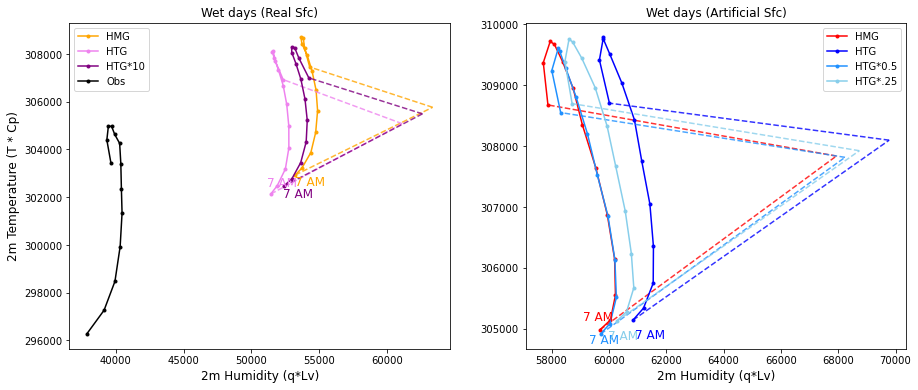

In [88]:
# Make the plots! 
fig,axs = plt.subplots(1,2, figsize=(15,6))
axs     = axs.ravel()


## Plot real surface
# - - - - - - - - - - - 

caseNames = np.asarray(['HMG','HTG','HTG*10'])
colorList = np.asarray(['orange','violet','purple'])
offset_7aText = np.asarray([ [1.0,    0.994, 0.999], 
                             [0.9985, 1.001, 0.9985] ])

for iCase in range(3):
    axs[0].plot(real_LvQ[:,iCase], real_CpT[:,iCase],'o-',
                markersize=3, color=colorList[iCase], label=caseNames[iCase])
    
    # Add vectors
    axs[0].plot([real_LvQ[0,iCase], real_LvQ[0,iCase]+real_L_delQ[iCase]], 
                [real_CpT[0,iCase], real_CpT[0,iCase]+real_Cp_delTheta[iCase]],
                '--', color=colorList[iCase], alpha=0.8)
    axs[0].plot([real_LvQ[0,iCase]+real_L_delQ[iCase], real_LvQ[-1,iCase]], 
                [real_CpT[0,iCase]+real_Cp_delTheta[iCase], real_CpT[-1,iCase]],
                '--', color=colorList[iCase], alpha=0.8)
    # Add 7 am labels
    axs[0].text(real_LvQ[0,iCase]*offset_7aText[0,iCase], 
                real_CpT[0,iCase]*offset_7aText[1,iCase], '7 AM', color=colorList[iCase], fontsize=12)
    
## Plot observations T/Q:
# - - - - - - - - - - - 
axs[0].plot( hourlyMean_wWet_Obs.q_srf.values[7:20]*Lv, 
            (hourlyMean_wWet_Obs.T_srf.values[7:20]+273.15)*Cp,'o-',
                markersize=3, color='k', label='Obs')


## Plot artificial surface
# - - - - - - - - - - - 
caseNames = np.asarray(['HMG','HTG'])
colorList = np.asarray(['red','blue'])
offset_7aText = np.asarray([ [0.99,    1.001 ], 
                             [1.0005,  0.999   ] ])

for iCase in range(2): 
    axs[1].plot(art_LvQ[:,iCase], art_CpT[:,iCase],'o-',
                markersize=3, color=colorList[iCase], label=caseNames[iCase])
    
    # Add vectors
    axs[1].plot([art_LvQ[0,iCase], art_LvQ[0,iCase]+art_L_delQ[iCase]], 
                [art_CpT[0,iCase], art_CpT[0,iCase]+art_Cp_delTheta[iCase]],
                '--', color=colorList[iCase], alpha=0.8)
    axs[1].plot([art_LvQ[0,iCase]+art_L_delQ[iCase], art_LvQ[-1,iCase]], 
                [art_CpT[0,iCase]+art_Cp_delTheta[iCase], art_CpT[-1,iCase]],
                '--', color=colorList[iCase], alpha=0.8)
    # Add 7 am labels
    axs[1].text(art_LvQ[0,iCase]*offset_7aText[0,iCase], 
                art_CpT[0,iCase]*offset_7aText[1,iCase], '7 AM', color=colorList[iCase], fontsize=12)
    
    
# Add multipliers
caseNames = np.asarray(['HTG*0.5','HTG*.25'])
colorList = np.asarray(['dodgerblue','skyblue'])
offset_7aText = np.asarray([ [0.993,   0.995 ], 
                             [0.9995,  0.999   ] ])

for iCase in range(2): 
    axs[1].plot(artMult_LvQ[:,iCase], artMult_CpT[:,iCase],'o-',
                markersize=3, color=colorList[iCase], label=caseNames[iCase])
    
    # Add vectors
    axs[1].plot([artMult_LvQ[0,iCase], artMult_LvQ[0,iCase]+artMult_L_delQ[iCase]], 
                [artMult_CpT[0,iCase], artMult_CpT[0,iCase]+artMult_Cp_delTheta[iCase]],
                '--', color=colorList[iCase], alpha=0.8)
    axs[1].plot([artMult_LvQ[0,iCase]+artMult_L_delQ[iCase], artMult_LvQ[-1,iCase]], 
                [artMult_CpT[0,iCase]+artMult_Cp_delTheta[iCase], artMult_CpT[-1,iCase]],
                '--', color=colorList[iCase], alpha=0.8)
    # Add 7 am labels
    axs[1].text(artMult_LvQ[0,iCase]*offset_7aText[0,iCase], 
                artMult_CpT[0,iCase]*offset_7aText[1,iCase], '7 AM', color=colorList[iCase], fontsize=12)
    


## Add titles/labels 
# - - - - - - - - - - - 
axs[0].set_ylabel('2m Temperature (T * Cp)', fontsize=12)
axs[0].set_xlabel('2m Humidity (q*Lv)',fontsize=12)
axs[1].set_xlabel('2m Humidity (q*Lv)',fontsize=12)


axs[0].set_title('Wet days (Real Sfc)')
axs[1].set_title('Wet days (Artificial Sfc)')

axs[0].legend()
axs[1].legend()


In [79]:
# The slope of the top vector is exactly equal to the bowen ratio of entrainment. 
#   Slope = rise/run 

caseNames = np.asarray(['HMG','HTG','HTG*10'])
bowen_entrainment_real = ( real_CpT[-1,:] - (real_CpT[0,:]+real_Cp_delTheta[:]) ) / ( real_LvQ[-1,:] - (real_LvQ[0,:]+real_L_delQ[:][:]) ) 

print('Real Surface Bowen_entrainment: ')
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', bowen_entrainment_real[iCase])
    
print('\nReal Surface V_sfc: ')
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', np.sqrt(real_Cp_delTheta[iCase]**2 + real_L_delQ[iCase]**2))
    

Real Surface Bowen_entrainment: 
HMG    :   -0.18629088
HTG    :   -0.21040262
HTG*10    :   -0.17967908

Real Surface V_sfc: 
HMG    :   10519.792439266703
HTG    :   10132.258413057058
HTG*10    :   10680.833004224784


In [80]:
# The slope of the top vector is exactly equal to the bowen ratio of entrainment. 
#   Slope = rise/run 

caseNames = np.asarray(['HMG','HTG','HTG*0.5','HTG*0.25'])

bowen_entrainment_art     = ( art_CpT[-1,:]     - (art_CpT[0,:]+art_Cp_delTheta[:]) )         / ( art_LvQ[-1,:]  - (art_LvQ[0,:]+art_L_delQ[:])) 
bowen_entrainment_artMult = ( artMult_CpT[-1,:] - (artMult_CpT[0,:]+artMult_Cp_delTheta[:]) ) / ( artMult_LvQ[-1,:] - (artMult_LvQ[0,:]+artMult_L_delQ[:]) ) 

bowen_entrainmentArtAll = np.append(bowen_entrainment_art, bowen_entrainment_artMult)
Cp_delTheta_artAll      = np.append(art_Cp_delTheta, artMult_Cp_delTheta)
L_delQ_artAll           = np.append(art_L_delQ, artMult_L_delQ)

print('Artificial Surface Bowen_entrainment: ')
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', bowen_entrainmentArtAll[iCase])
    
print('\nArtificial Surface V_sfc: ')
for iCase in range(len(caseNames)):
    print(caseNames[iCase], '   :  ', np.sqrt(Cp_delTheta_artAll[iCase]**2 + L_delQ_artAll[iCase]**2))
    
    

Artificial Surface Bowen_entrainment: 
HMG    :   -0.08338305
HTG    :   -0.062294014
HTG*0.5    :   -0.07409989
HTG*0.25    :   -0.07720676

Artificial Surface V_sfc: 
HMG    :   8725.868975039473
HTG    :   9410.788074235754
HTG*0.5    :   9004.70765529651
HTG*0.25    :   8906.115856994445
